In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchtext
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModel, AutoTokenizer, AutoConfig
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/feedback-prize-effectiveness/sample_submission.csv
/kaggle/input/feedback-prize-effectiveness/train.csv
/kaggle/input/feedback-prize-effectiveness/test.csv
/kaggle/input/feedback-prize-effectiveness/test/D72CB1C11673.txt
/kaggle/input/feedback-prize-effectiveness/train/87A6EF3113C6.txt
/kaggle/input/feedback-prize-effectiveness/train/24687D08CFDA.txt
/kaggle/input/feedback-prize-effectiveness/train/B64326635AB6.txt
/kaggle/input/feedback-prize-effectiveness/train/53858BE44997.txt
/kaggle/input/feedback-prize-effectiveness/train/02F89B4E55CF.txt
/kaggle/input/feedback-prize-effectiveness/train/4B048F74F3E7.txt
/kaggle/input/feedback-prize-effectiveness/train/62FC97D29846.txt
/kaggle/input/feedback-prize-effectiveness/train/FDE359A2F973.txt
/kaggle/input/feedback-prize-effectiveness/train/B72D0B4875B4.txt
/kaggle/input/feedback-prize-effectiveness/train/9A1DC81E4FB5.txt
/kaggle/input/feedback-prize-effectiveness/train/BACC53ECC1FB.txt
/kaggle/input/feedback-prize-effectiven

In [2]:
import re
from nltk.corpus import stopwords
import nltk
import string

In [3]:
from prettytable import PrettyTable

In [4]:
train_df = pd.read_csv('/kaggle/input/feedback-prize-effectiveness/train.csv')
train_df.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


In [5]:
print(f"train_df.shape: {train_df.shape}")

train_df.shape: (36765, 5)


In [6]:
columns = train_df.columns.values.tolist()
print(columns)

['discourse_id', 'essay_id', 'discourse_text', 'discourse_type', 'discourse_effectiveness']


In [32]:
essays = []

print("Some Essay Examples: ")
print()

ids = train_df['essay_id'].values.tolist()
print(len(ids))
print(len(ids))
ids = list(set(ids))
for id in ids[:15]:
    file = open(f"/kaggle/input/feedback-prize-effectiveness/train/{id}.txt").read()
    essays.append(str(file[:250]))

t = PrettyTable(['Eg. 1', 'Eg. 2', 'Eg. 3', 'Eg. 4', 'Eg. 5'], max_table_width = 130)

for i in range(0, len(essays), 5):
    essay_list = []
    for j in range(0, 5):
        essay_list.append(essays[i+j])
    t.add_row(essay_list)
print(t)

Some Essay Examples: 

36765
36765
+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+
|           Eg. 1           |           Eg. 2           |           Eg. 3           |           Eg. 4           |           Eg. 5           |
+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+
|     Phones & Driving .    |  The use of technology to |   The united states has   |  The author suggest that  |    Dear State Senator ,   |
|                           |     read the emotional    |   this ellection system   |    studying Venus is a    |                           |
| Technology has made a big |  expressions of students  |    called the electoral   | worthy pursuit because it |  The electoral college is |
|    impact on the world    |     in a classroom is     |   collage. The electoral  |  is often referred to as  |

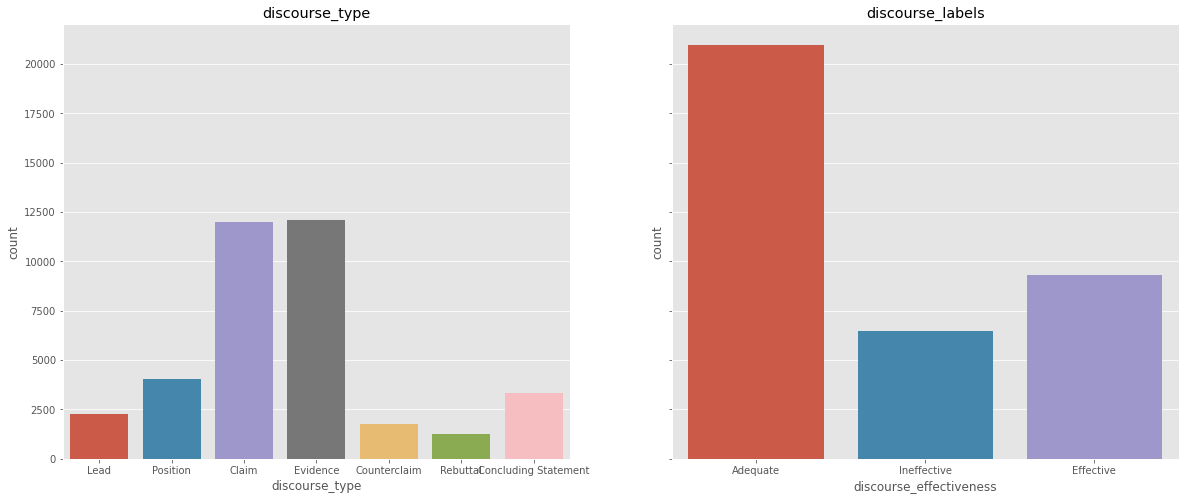

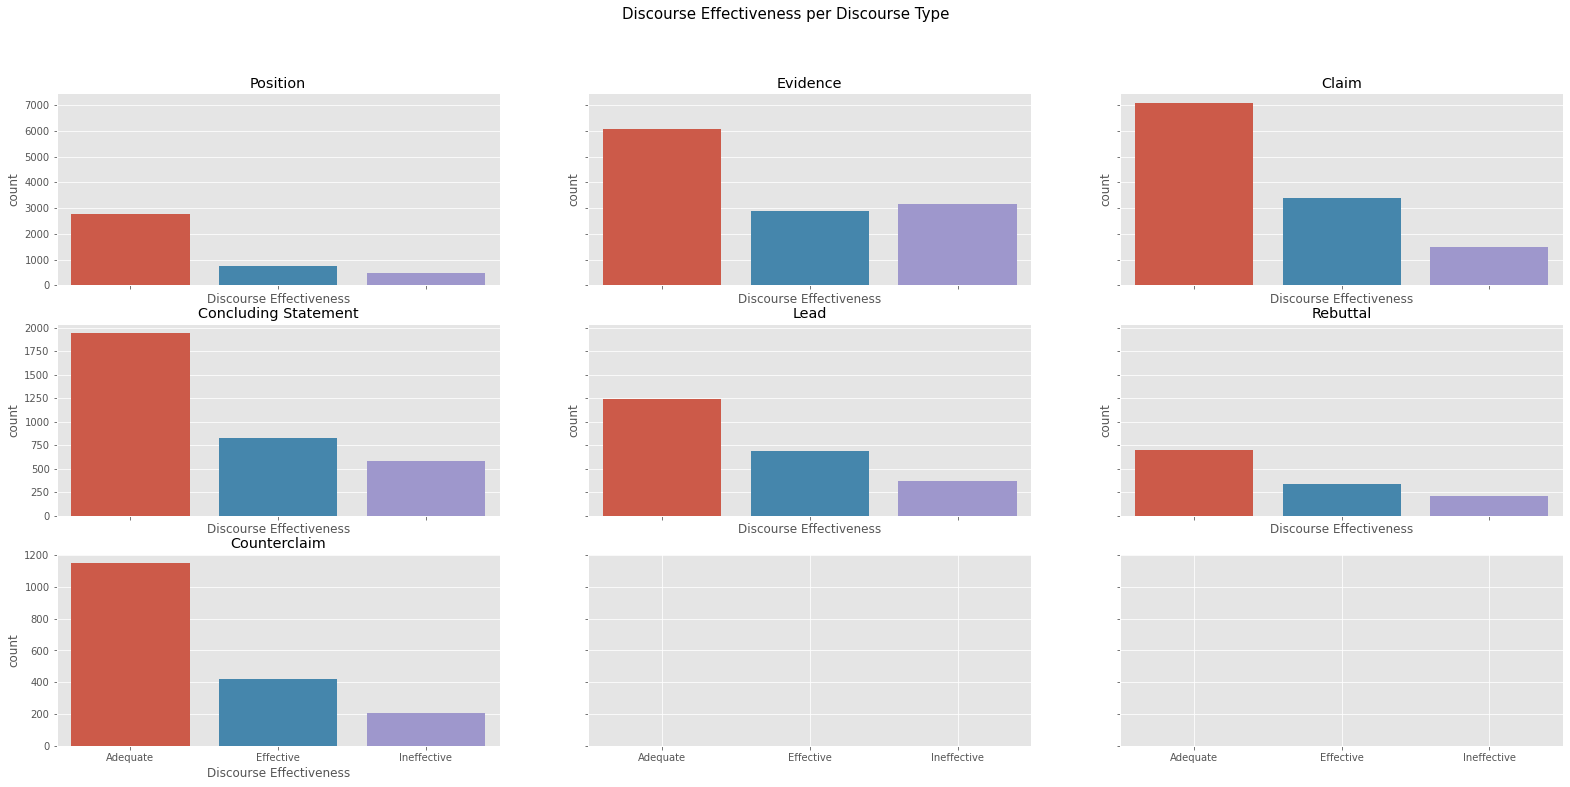

In [33]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(20, 8))

axis1 = axes[0]
axis1.set_title('discourse_type')

sns.countplot(x="discourse_type", data = train_df, ax = axis1)

axis2 = axes[1]
axis2.set_title('discourse_labels')

sns.countplot(x='discourse_effectiveness', data=train_df,ax=axis2)

fig.show()

discourse_types = list(set(train_df['discourse_type'].values.tolist()))

fig, axes = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(27, 12))

labels = ['Adequate', 'Effective', 'Ineffective']
axes = axes.flatten()

for i, discourse_type in enumerate(discourse_types):
    axis = axes[i]
    filtered_df = train_df[train_df['discourse_type'] == discourse_type]
    sns.countplot(x="discourse_effectiveness", data=filtered_df, ax=axis, order=labels)
    axis.set_title(discourse_type)
    axis.set(xlabel="Discourse Effectiveness")
fig.suptitle('Discourse Effectiveness per Discourse Type', fontsize=15)
plt.show()

In [34]:
def print_examples(discourse_type):
    print(discourse_type)
    t = PrettyTable(['Ineffective', 'Adequate', 'Effective'], max_table_width = 130)
    
    filtered = train_df[train_df['discourse_type']==discourse_type]
    content = []
    for label in labels:
        text = filtered[filtered['discourse_effectiveness']==label]
        text = text.iloc[0]
        content.append(text.discourse_text)
    t.add_row(content)
    print(t)

print(discourse_types)
[print_examples(discourse_type) for discourse_type in discourse_types]

['Position', 'Evidence', 'Claim', 'Concluding Statement', 'Lead', 'Rebuttal', 'Counterclaim']
Position
+-----------------------------------------------+---------------------------------------------+-----------------------------------------+
|                  Ineffective                  |                   Adequate                  |                Effective                |
+-----------------------------------------------+---------------------------------------------+-----------------------------------------+
| On my perspective, I think that the face is a |  With so many things in this world that few |  There are many sides to people giving  |
|   natural landform because I dont think that  |  people agree on, this is a nice change to  |   up their cars. Some people are truly  |
|  there is any life on Mars. In these next few | see in regards the removal of so many cars. |  happy and some are not. It may not be  |
| paragraphs, I'll be talking about how I think |   Why would they al

[None, None, None, None, None, None, None]

In [5]:
random_seed = 64
epochs = 5
model_name = "microsoft/deberta-v3-base"
dropout = 0.2
batch_size = 8
max_length = 290
lr = 0.01
seed = 102
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
import warnings
warnings.filterwarnings("ignore")
import logging
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast = True)

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/579 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

In [8]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

In [9]:
def map_labels(x):
    if x =='Adequate':
        return 1
    if x=='Effective':
        return 2
    return 0

train_df['labels'] = train_df['discourse_effectiveness'].apply(lambda x: map_labels(x))

In [10]:
class CustomDataset(Dataset):
    def __init__(self, df, tokenizer, max_len, data_path):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.data_path = data_path
        
        self.text = df['discourse_text'].values
        self.ids = df['essay_id'].values
        self.disc_type = df['discourse_type'].values
        self.labels = df['labels'].values
        
    def __getitem__(self, index):
        text = self.text[index]
        discourse_type = self.disc_type[index]

        essay_file_path = os.path.join(self.data_path, f"{self.ids[index]}.txt")
        essay = open(essay_file_path, 'r').read()

        text_idx = max(0, essay.find(text))
        bef_idx = max(essay[:text_idx].rfind('.'), 0)
        text_bef = essay[bef_idx:text_idx]
        if len(text_bef)>self.max_len:
            text_bef = ""
        text = discourse_type + " " + self.tokenizer.sep_token + " " + str(text_bef) + " " + self.tokenizer.sep_token + " " + text
        inputs = self.tokenizer.encode_plus(text, truncation=True, add_special_tokens=True, max_length = self.max_len)

        return {'input_ids': inputs['input_ids'], 'attention_mask': inputs['attention_mask'], 'labels': self.labels[index]}

    def __len__(self):
        return len(self.df)


In [11]:
class DebertaV3Model(nn.Module):
    def __init__(self, model_base, dropout):
        super(DebertaV3Model, self).__init__()
        
        self.model = AutoModel.from_pretrained(model_base)
        self.config = AutoConfig.from_pretrained(model_base)
        self.dropout = nn.Dropout(p=dropout)
        
        for parameter in self.model.parameters():
            parameter.requires_grad = True
        
        self.mean_pooling = MeanPooling()
        self.fc1 = nn.Linear(self.config.hidden_size, 3)
    
    def forward(self, ids, masks):
        outs = self.model(input_ids = ids, attention_mask = masks, output_hidden_states = False)
        out = self.dropout(self.mean_pooling(outs.last_hidden_state, masks))
        #print(out.shape, "out")
        output = self.fc1(out)
        #print(output.shape, "output")
        
        return output
    
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
    
    def forward(self, last_hidden_state, mask):
        #print(last_hidden_state.shape, "last_hidden_state")
        #print(mask.shape, "attn_mask")
        expanded_mask = mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        #print(expanded_mask.shape, "expanded_mask")
        embeddings = last_hidden_state*expanded_mask
        embed_sum = torch.sum(embeddings, 1)
        #print(embeddings.shape, "embeddgins", embed_sum.shape, "embed_sum")
        mask_sum = torch.clamp(expanded_mask.sum(1), min = 1e-8)
        #print(mask_sum.shape, "mask_sum_attn")
        mean_pooled = embed_sum/mask_sum
        #print(mean_pooled.shape, "mean_pooled")
        return mean_pooled

In [12]:
import tqdm

In [13]:
def train(epoch, model, opt, lr_scheduler, criterion, dataloader, device):
    print(f"Epoch: {epoch}")
    model.train()
    
    running_loss = 0
    total_loss = []
    lrs = []
    total_size = 0
    correct = 0
    
    print(dataloader)
    progress_bar = tqdm.tqdm(dataloader, total = len(dataloader))
    
    for i, data in enumerate(dataloader):
        ids = data["input_ids"].to(device, dtype=torch.long)
        mask = data["attention_mask"].to(device, dtype=torch.long)
        labels = data["labels"].to(device, dtype=torch.long)
        
        #print(ids.shape, "ids")
        batch_size = ids.size(0)
        
        output = model(ids, mask)
        loss = criterion(output, labels)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        if i%4 == 0 or i+1==len(dataloader):
            lr_scheduler.step()
        total_loss.append(loss.item())
        
        temp, preds = output.max(1)
        correct += (preds == labels).float().sum().item()
        total_size += batch_size
        
        accuracy = correct/total_size
        
        progress_bar.set_postfix(Loss=np.sum(np.array(total_loss)), Accuracy=accuracy, LR=opt.param_groups[0]['lr'])
        
        lrs.append(opt.param_groups[0]['lr'])
    
    return np.mean(np.array(total_loss)), accuracy, lrs

def valid_eval(model, dataloader, device):
    model.eval()
    
    total_size = 0
    total_loss = []
    correct = 0
    
    for data in dataloader:
        ids = data["input_ids"].to(device, dtype=torch.long)
        mask = data["attention_mask"].to(device, dtype=torch.long)
        labels = data["labels"].to(device, dtype=torch.long)
        
        #print(ids.shape, "ids")
        batch_size = ids.size(0)
        
        output = model(ids, mask)
        loss = criterion(output, labels)
        
        total_loss.append(loss.item())
        
        temp, preds = output.max(1)
        correct += (preds == labels).float().sum().item()
        total_size += batch_size
        
    
    accuracy = correct/total_size
    
    print("Validation Loss: {:.4f} Accuracy: {:.2f}%".format(np.mean(np.array(total_loss)), accuracy))
    model.train()
    return np.mean(np.array(total_loss)), accuracy

In [14]:
import copy

In [15]:
def train_epochs(model, opt, lr_scheduler, criterion, device, epochs=25):
    min_avg_loss = 1e9
    max_accuracy = 0
    history = {"Train Loss": [], "Valid Loss": [], "Train Acc": [], "Valid Acc": [], "LRs": []}
    
    for epoch in range(epochs):
        train_loss, train_accuracy, lrs = train(epoch, model, opt, lr_scheduler, criterion, dataloader = train_loader, device=device)
        
        valid_loss, valid_accuracy = valid_eval(model, dataloader=valid_loader, device=device)
        
        history["Train Loss"].append(train_loss)
        history["Valid Loss"].append(valid_loss)
        history["Train Acc"].append(train_accuracy)
        history["Valid Acc"].append(valid_accuracy)
        history["LRs"].extend(lrs)
        
        if valid_loss < min_avg_loss:
            print(f"Validation Loss Improved ({min_avg_loss} ---> {valid_loss})")
            min_avg_loss = valid_loss
            max_accuracy = valid_accuracy
            best_model_weights = copy.deepcopy(model.state_dict())
            path = f"best_model.bin"
            torch.save(model.state_dict(), path)
            print(f"Model Saved")
        
        print('-'*89)
        
    
    print("Minimum Loss: {:.4f} Best Accuracy: {:.2f}".format(min_avg_loss, max_accuracy))
    
    model.load_state_dict(best_model_weights)
    return model, history

In [16]:
train_df = train_df.drop(['discourse_effectiveness'], axis=1)

In [17]:
train_df = train_df.sample(frac=0.7)

In [18]:
df_train, df_valid = train_test_split(train_df, test_size=0.2, random_state=47, stratify = train_df.labels)
df_train.shape, df_valid.shape

((20588, 5), (5148, 5))

In [19]:
from transformers import DataCollatorWithPadding

train_dir = "../input/feedback-prize-effectiveness/train"
test_dir = "../input/feedback-prize-effectiveness/test"

In [20]:
train_dataset = CustomDataset(df_train, tokenizer=tokenizer, max_len=max_length, data_path=train_dir)
valid_dataset = CustomDataset(df_valid, tokenizer=tokenizer, max_len=max_length, data_path=train_dir)

collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)
train_loader = DataLoader(train_dataset,batch_size=batch_size,collate_fn=collate_fn,num_workers=2,shuffle=True,pin_memory=True)
valid_loader = DataLoader(valid_dataset,batch_size=batch_size,collate_fn=collate_fn,num_workers=2,shuffle=False,pin_memory=True)

In [21]:
model = DebertaV3Model(model_name, dropout)
model.to(device)

model_parameters = filter(lambda parameter: parameter.requires_grad, model.parameters())
optimizer = torch.optim.AdamW(model_parameters, lr=lr)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=500, eta_min=0.002)
criterion = nn.CrossEntropyLoss()

model, history = train_epochs(model, optimizer, scheduler,criterion, device=device, epochs=epochs)

Downloading:   0%|          | 0.00/354M [00:00<?, ?B/s]

Epoch: 0


  0%|          | 0/2574 [08:57<?, ?it/s, Accuracy=0.566, LR=0.00355, Loss=2.63e+3]


Validation Loss: 0.9933 Accuracy: 0.57%
Validation Loss Improved (1000000000.0 ---> 0.993263460927128)
Model Saved
-----------------------------------------------------------------------------------------
Epoch: 1


  0%|          | 0/2574 [08:59<?, ?it/s, Accuracy=0.566, LR=0.00501, Loss=2.56e+3]


Validation Loss: 0.9756 Accuracy: 0.57%
Validation Loss Improved (0.993263460927128 ---> 0.9755740603489905)
Model Saved
-----------------------------------------------------------------------------------------
Epoch: 2


  0%|          | 0/2574 [08:56<?, ?it/s, Accuracy=0.567, LR=0.00967, Loss=2.54e+3]


Validation Loss: 0.9822 Accuracy: 0.57%
-----------------------------------------------------------------------------------------
Epoch: 3


  0%|          | 0/2574 [08:58<?, ?it/s, Accuracy=0.57, LR=0.00249, Loss=2.54e+3] 


Validation Loss: 0.9744 Accuracy: 0.57%
Validation Loss Improved (0.9755740603489905 ---> 0.9744051700423223)
Model Saved
-----------------------------------------------------------------------------------------
Epoch: 4


  0%|          | 0/2574 [08:56<?, ?it/s, Accuracy=0.563, LR=0.00663, Loss=2.56e+3]


Validation Loss: 1.0182 Accuracy: 0.57%
-----------------------------------------------------------------------------------------
Minimum Loss: 0.9744 Best Accuracy: 0.57


In [22]:
def pre_process(x):
  x = x.lower()
  x = re.compile('<.*?>').sub(' ', x)
  x = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', x)

  return x

In [24]:
train_df['discourse_text'] = train_df['discourse_text'].apply(lambda x: pre_process(x))

train_df.head()

,discourse_id,essay_id,discourse_text,discourse_type,labels
17228,39579533e637,28DB1BCCB6AF,i see these sort of devices extremely helpful ...,Evidence,1
35199,2d8046c20efb,8C15FC3C3BCB,in prison solitary confinement is a punishmen...,Evidence,2
12835,6b3be41da737,E76B78A22B99,and a lot of people think its by aliens and th...,Evidence,0
28838,b084881b0c18,C2BAF4ADA2CA,most counterclaims to my explanation is swing...,Counterclaim,0
31279,c4707bd40eed,E740029E13D1,now no one would know if this is true but the ...,Rebuttal,2


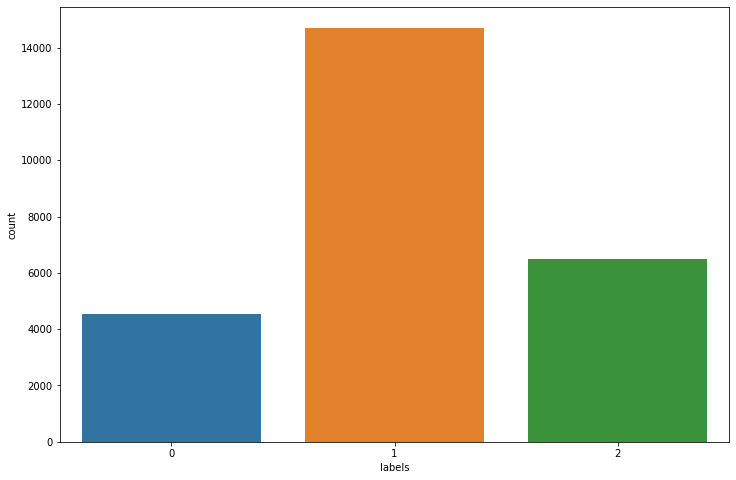

In [27]:
import seaborn as sns
plt.figure(figsize=(12,8))
sns.countplot(x="labels", data=train_df)
plt.show()

In [30]:
train_df = train_df[['discourse_id','discourse_text','labels']].dropna()

In [31]:
text = train_df['discourse_text'].tolist()

print(type(text), len(list(text)))

<class 'list'> 25736


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

In [35]:
cv = CountVectorizer(max_features = 500)

x = cv.fit_transform(text).toarray()
y = np.array(train_df['labels'].values)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15, random_state = 100)

In [36]:
classifier = GaussianNB()
classifier.fit(x_train, y_train)

GaussianNB()

In [37]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [38]:
y_pred = classifier.predict(x_test)

confs_matrx = confusion_matrix(y_test, y_pred)
score = accuracy_score(y_test, y_pred)
print("Confusion_Matrix")
print(confs_matrx)
print(score)

Confusion_Matrix
[[ 195  410   61]
 [ 345 1570  278]
 [  63  510  429]]
0.5682465682465683
